In [25]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def readDatas(path):
    network = nx.read_gml(path) 
    noduri = [nod for nod in network.nodes()]
    arce = [arc for arc in network.edges()]
    return noduri, arce

def getMatriceDeAdiacenta(noduri, arce):
    matriceDeAdiacenta = [[0 for _ in range(0, len(noduri))] for _ in range(0, len(noduri))]
    for i in range(0, len(noduri)):
        for j in range(0, len(noduri)):
            if (noduri[i], noduri[j]) in arce:
                matriceDeAdiacenta[i][j] = 1
            else:
                matriceDeAdiacenta[i][j] = 0
    return matriceDeAdiacenta

def drawNetwork(network, communities=None):
    noduri, arce = network

    if communities == None:
        communities = [1 for _ in range(0, len(noduri))]
    
    matriceDeAdiacenta = getMatriceDeAdiacenta(noduri, arce)
    a = np.matrix(matriceDeAdiacenta)
    g = nx.from_numpy_array(a)
    pos = nx.spring_layout(g)

    plt.figure(figsize=(15, 15))
    nx.draw_networkx_nodes(g, pos, node_size=300, cmap=plt.cm.RdYlBu, node_color=communities)
    nx.draw_networkx_edges(g, pos, alpha=0.3)
    plt.show()

In [31]:
from random import randint

class Chromosome:
    def __init__(self, problParam = None):
        self.__problParam = problParam
        self.__repres = [randint(1, problParam['nrNoduri'] + 1) for _ in range(problParam['nrNoduri'])]
        self.__fitness = 0.0
    
    @property
    def repres(self):
        return self.__repres
    
    @property
    def fitness(self):
        return self.__fitness 
    
    @repres.setter
    def repres(self, l = []):
        self.__repres = l 
    
    @fitness.setter 
    def fitness(self, fit = 0.0):
        self.__fitness = fit 
    
    def crossover(self, c):
        r = randint(0, len(self.__repres) - 1)
        newrepres = []
        for i in range(r):
            newrepres.append(self.__repres[i])
        for i in range(r, len(self.__repres)):
            newrepres.append(c.__repres[i])
        offspring = Chromosome(c.__problParam)
        offspring.repres = newrepres
        return offspring
    
    def mutation(self):
        pos = randint(0, len(self.__repres) - 1)
        self.__repres[pos] = randint(1, self.__problParam['nrNoduri'] + 1)
        
    def __str__(self):
        return '\nChromo: ' + str(self.__repres) + ' has fit: ' + str(self.__fitness)
    
    def __repr__(self):
        return self.__str__()
    
    def __eq__(self, c):
        return self.__repres == c.__repres and self.__fitness == c.__fitness

In [32]:
from random import randint

class GA:
    def __init__(self, param = None, problParam = None):
        self.__param = param
        self.__problParam = problParam
        self.__population = []
        
    @property
    def population(self):
        return self.__population
    
    def initialisation(self):
        for _ in range(0, self.__param['popSize']):
            c = Chromosome(self.__problParam)
            self.__population.append(c)
    
    def evaluation(self):
        for c in self.__population:
            c.fitness = self.__problParam['function'](c.repres, self.__problParam)
            
    def bestChromosome(self):
        best = self.__population[0]
        for c in self.__population:
            if (c.fitness < best.fitness):
                best = c
        return best
        
    def worstChromosome(self):
        best = self.__population[0]
        for c in self.__population:
            if (c.fitness > best.fitness):
                best = c
        return best

    def selection(self):
        pos1 = randint(0, self.__param['popSize'] - 1)
        pos2 = randint(0, self.__param['popSize'] - 1)
        if (self.__population[pos1].fitness < self.__population[pos2].fitness):
            return pos1
        else:
            return pos2 
        
    
    def oneGeneration(self):
        newPop = []
        for _ in range(self.__param['popSize']):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2)
            off.mutation()
            newPop.append(off)
        self.__population = newPop
        self.evaluation()

    def oneGenerationElitism(self):
        newPop = [self.bestChromosome()]
        for _ in range(self.__param['popSize'] - 1):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2)
            off.mutation()
            newPop.append(off)
        self.__population = newPop
        self.evaluation()
        
    def oneGenerationSteadyState(self):
        for _ in range(self.__param['popSize']):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2)
            off.mutation()
            off.fitness = self.__problParam['function'](off.repres)
            worst = self.worstChromosome()
            if (off.fitness < worst.fitness):
                worst = off       

In [43]:
def gradulUnuiNod(nod, matriceDeAdiacenta, nrNoduri):
    grad = 0
    for i in range(0, nrNoduri):
        if matriceDeAdiacenta[nod][i] == 1:
            grad += 1
    return grad

def modularitate(communities, problemParameters):
    matriceDeAdiacenta = getMatriceDeAdiacenta(problemParameters["noduri"], problemParameters["arce"])
    nrNoduri = problemParameters["nrNoduri"]
    nrArce = problemParameters["nrArce"]

    suma = 0
    for i in range(0, nrNoduri):
        for j in range(0, nrNoduri):
            if communities[i] == communities[j]:
                elementMatrice = matriceDeAdiacenta[i][j]
                gradNodi = gradulUnuiNod(i, matriceDeAdiacenta, nrNoduri)
                gradNodj = gradulUnuiNod(j, matriceDeAdiacenta, nrNoduri)
                suma += elementMatrice - (gradNodi * gradNodj)/(2*nrArce)
    modularitatea = suma/(4*nrArce)
    return modularitatea

def noduriDinComunitate(communities, community):
    indici = []
    for i in range(0, len(communities)):
        if communities[i] == community:
            indici.append(i)
    return indici
    
def densitateaInternaAUneiComunitati(communities, problemParameters):
    suma = 0
    for community in set(communities):
        indiciNoduri = noduriDinComunitate(communities, community)
        nrNoduri = len(indiciNoduri)
        nrArcePosibile = nrNoduri*(nrNoduri - 1)//2

        nrArceExistente = 0
        for i in indiciNoduri:
            for j in indiciNoduri:
                if (problemParameters["noduri"][i], problemParameters["noduri"][j]) in problemParameters["arce"]:
                    nrArceExistente += 1
        if nrArcePosibile != 0:
            suma += nrArceExistente / nrArcePosibile

    return suma/len(set(communities))

def conectivitateaInternaSiExternaAComunitatilor(communities, problemParameters):
    suma = 0
    for community in set(communities):
        indiciNoduri = noduriDinComunitate(communities, community)
        nrNoduri = len(indiciNoduri)

        nrArceExterior = 0
        for i in indiciNoduri:
            for j in [ind for ind in range(problemParameters["nrNoduri"]) if ind not in indiciNoduri]:
                if (problemParameters["noduri"][i], problemParameters["noduri"][j]) in problemParameters["arce"]:
                    nrArceExterior += 1

        nrArceDinInterior = 0
        for i in indiciNoduri:
            for j in indiciNoduri:
                if (problemParameters["noduri"][i], problemParameters["noduri"][j]) in problemParameters["arce"]:
                    nrArceDinInterior += 1
        if nrArceExterior != 0:
            suma += nrArceDinInterior / nrArceExterior
    return suma/len(set(communities))


In [44]:
def drawCommunities(network, functia_de_fitness):
    noduri, arce = network
    # initialise de GA parameters
    gaParam = {'popSize' : 10, 'noGen' : 3, 'pc' : 0.8, 'pm' : 0.1}
    # problem parameters
    problParam = {'nrNoduri' : len(noduri), 'nrArce' : len(arce), 'function' : functia_de_fitness, 'noduri' : noduri, 'arce' : arce}

    # store the best/average solution of each iteration (for a final plot used to anlyse the GA's convergence)
    allBestFitnesses = []
    allAvgFitnesses = []
    generations = []
    maxFitness = -9999
    bestSolution = []

    ga = GA(gaParam, problParam)
    ga.initialisation()
    ga.evaluation()
        
    for g in range(gaParam['noGen']):
        #plotting preparation
        allPotentialSolutionsX = [c.repres for c in ga.population]
        allPotentialSolutionsY = [c.fitness for c in ga.population]
        bestSolX = ga.bestChromosome().repres
        bestSolY = ga.bestChromosome().fitness
        allBestFitnesses.append(bestSolY)
        allAvgFitnesses.append(sum(allPotentialSolutionsY) / len(allPotentialSolutionsY))
        generations.append(g)
        
        #logic alg
        ga.oneGeneration()
        # ga.oneGenerationElitism()
        # ga.oneGenerationSteadyState()
        
        bestChromo = ga.bestChromosome()
        if bestChromo.fitness > maxFitness:
            maxFitness = bestChromo.fitness
            bestSolution = bestChromo.repres

    drawNetwork(network, bestSolution)
        

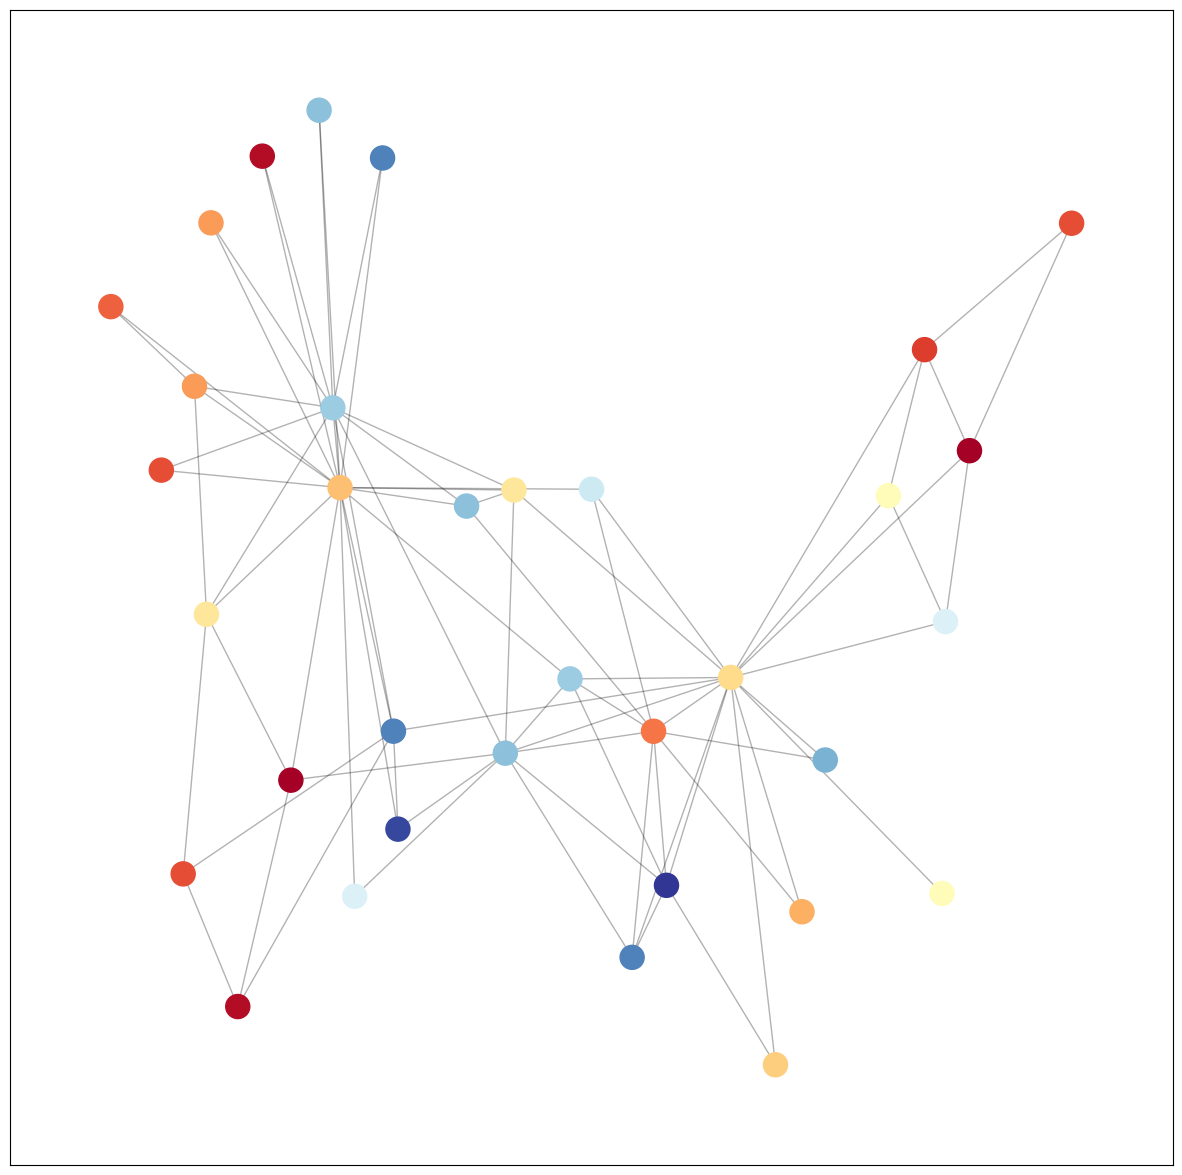

In [45]:
network = readDatas("realNetworks/karate.gml")
drawCommunities(network, functia_de_fitness=conectivitateaInternaSiExternaAComunitatilor)